# Patch Tester
This notebook contains the work I did in creating the training patches used in the Image Classifier notebook. Mostly work in generating overlapping training patches that occur within the 30 degree altitude contour.

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import morphology

In [168]:
from PIL import Image
import os
import math

## KPNO
The first set of cells demonstrates the work for images from the KPNO all sky camera.

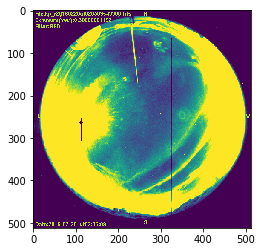

In [169]:
name = "20160220-r_ut020509s43380.png"
loc = os.path.join("Images", *["data", "val", "0.3", name])
with open(loc, "rb") as f:
    im = Image.open(f).convert('L')
    im = np.asarray(im).reshape((512, 512))
    
plt.imshow(im)

The following cell is kept for posterity. It is the original patch generation code, where I simply took the center of every patch to be any pixel that doesn't get masked out by the masking image.

In [170]:
pixels = []

# Gets the correct masking image which determines which pixels we're going to analyze.
loc = os.path.join('Images', *['data', 'mask.png'])
img = np.asarray(Image.open(loc).convert('L'))

# Everything that wouldn't normally get masked is a pixel we want to analyze.
for row in range(0, img.shape[0]):
    for column in range(0, img.shape[1]):
        if img[row, column] == 0:
            pixels.append([row, column])

The following cells test the grey scale morphology I apply to the images to test that it works in smoothing out local minima and maxima for the network. I load the image and then run a closing (smooths minima) and an opening (smooths maxima) over the image. I run the opening with a smaller kernel so as to better preserve the global structure since the smoothing it applies is mainly to 1x1 pixel squares.

In [171]:
im3 = morphology.grey_closing(im, size=(3,3))
im3 = morphology.grey_opening(im3, size=(2,2))

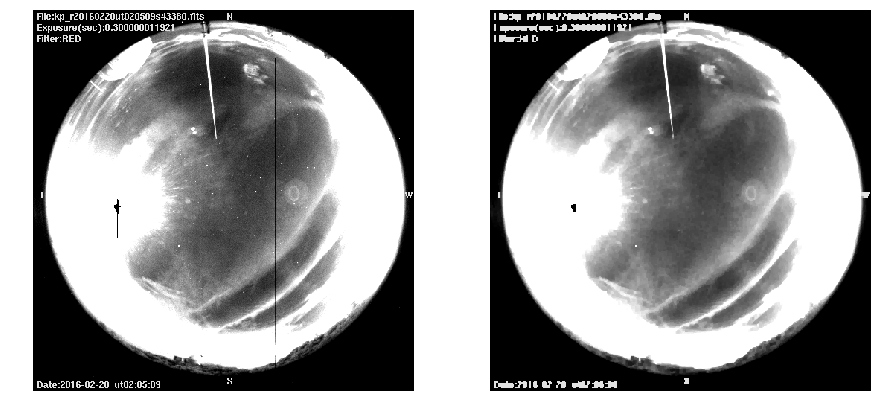

In [172]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
ax[0].set_axis_off()
ax[1].imshow(im3, cmap='gray', vmin=0, vmax=255)
ax[1].set_axis_off()

p2 (for pixel2) is the second pass at generating training patches. It's not brilliant, nor is it straightforward, but it worked (sort of). The method generates 4 grids with 32 pixel spaced lines, shifted by 8 each time. I then shave off the corner items so that the grid covers the entire image. The problem with this method was that I didn't shift the x and y axes independently. Hence the grid coverage and overlap is asymmetrical, which becomes clearer when you try to restrict it to only grid patches within the 30 degree altitude contour.

In [173]:
p2 = []

m = {0: [], 8: [], 16: [], 24: []}

for shift in range(0, 25, 8):
    #shift = 16
    # By subtracting 8 from the upper bound of 512 we prevent 
    # the grid from overruning the image edges for all shifts.
    x = np.arange(16 + shift, 504, 32)
    xx, yy = np.meshgrid(x, x, indexing='ij')
    xx = xx.reshape(xx.shape[0], xx.shape[1], 1)
    yy = yy.reshape(xx.shape[0], xx.shape[1], 1)
    grid = np.concatenate((xx, yy), axis=2)
    
    # The masked pixels take out the corners which we don't want to analyze.
    mask = np.ones(grid.shape, dtype=bool)

    # Removes a diagonal long the corners
    for i in range(-4, 4):
        for j in range(-4, 4):
            ii  = i if i < 0 else i+1
            jj  = j if j < 0 else j+1
            if abs(jj) + abs(ii) <= 5:
                mask[i,j] = False
    # Locations set to False are removed, then we reshape
    # into a single list of positions
    p2.append(grid[mask].reshape(-1, 2))
    m[shift].append(grid[mask].reshape(-1, 2))

p2 = np.concatenate(p2)

for key, value in m.items():
    m[key] = np.concatenate(value)

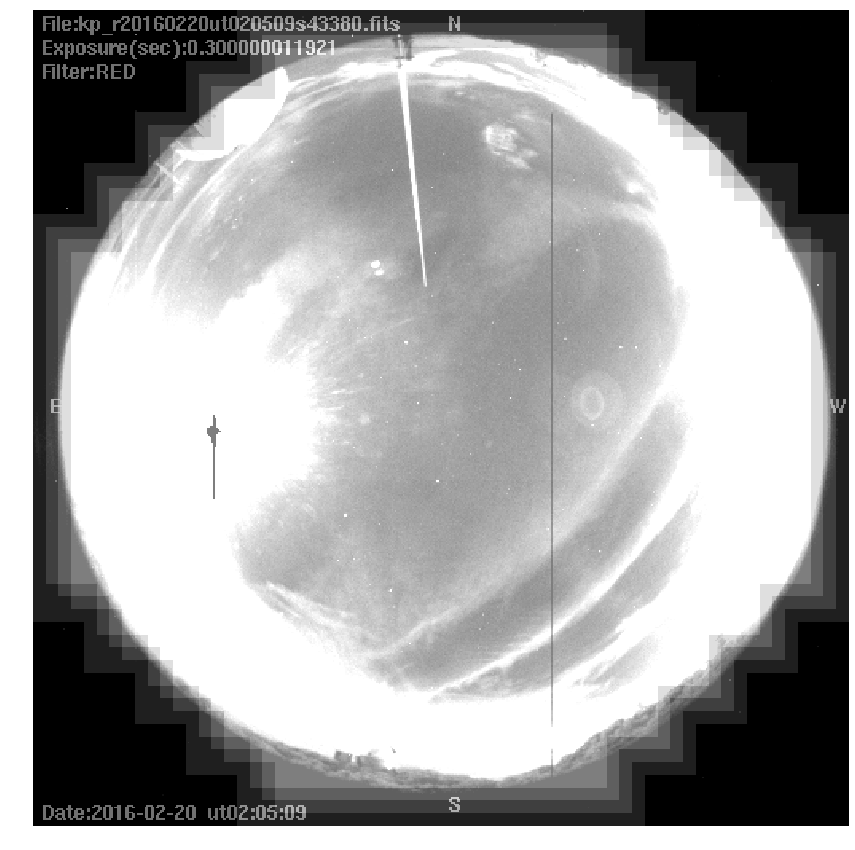

In [174]:
im2 = np.copy(im).astype('uint16')
mask = np.zeros((512,512))

for key, value in m.items():
    for pos in value:
        mask[pos[0]-16: pos[0]+16, pos[1]-16:pos[1]+16] += 1

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.imshow(im2, cmap='gray')
ax.imshow(mask, cmap='gray', alpha=0.5)
ax.set_axis_off()

The grid itself looks nice and symmetric, but as the image above shows the overlaps themselves are not.

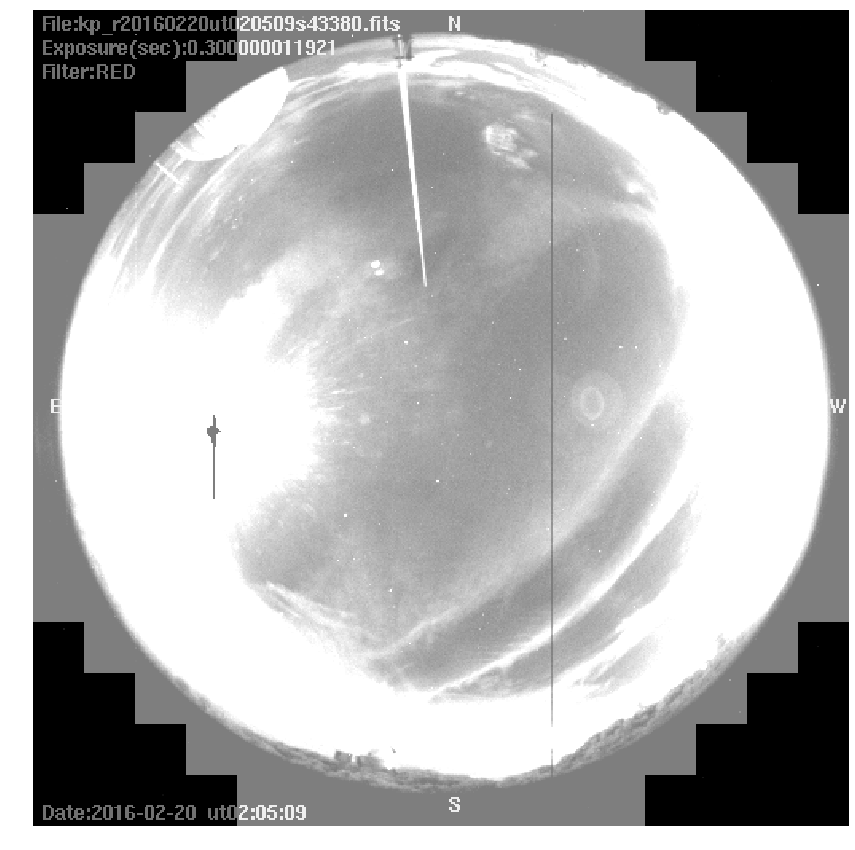

In [175]:
im2 = np.copy(im).astype('uint16')
im3 = np.zeros((512,512))
for pos in p2:
    im3[pos[0]-16: pos[0]+16, pos[1]-16:pos[1]+16] = 1

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.imshow(im2, cmap='gray')
ax.imshow(im3, cmap='gray', alpha=0.5)
ax.set_axis_off()

In order to test the 30 degree contour I load my AllSkyImage and draw contours so I can visually see where the grid needs to stop

In [176]:
import importlib
import image
from image import AllSkyImage
importlib.reload(image)

<module 'image' from '/Users/dylan/repos/kitt-peak/image.py'>

In [177]:
allsky = AllSkyImage(name, None, "KPNO", im2)
allsky2 = image.draw_contours(allsky)

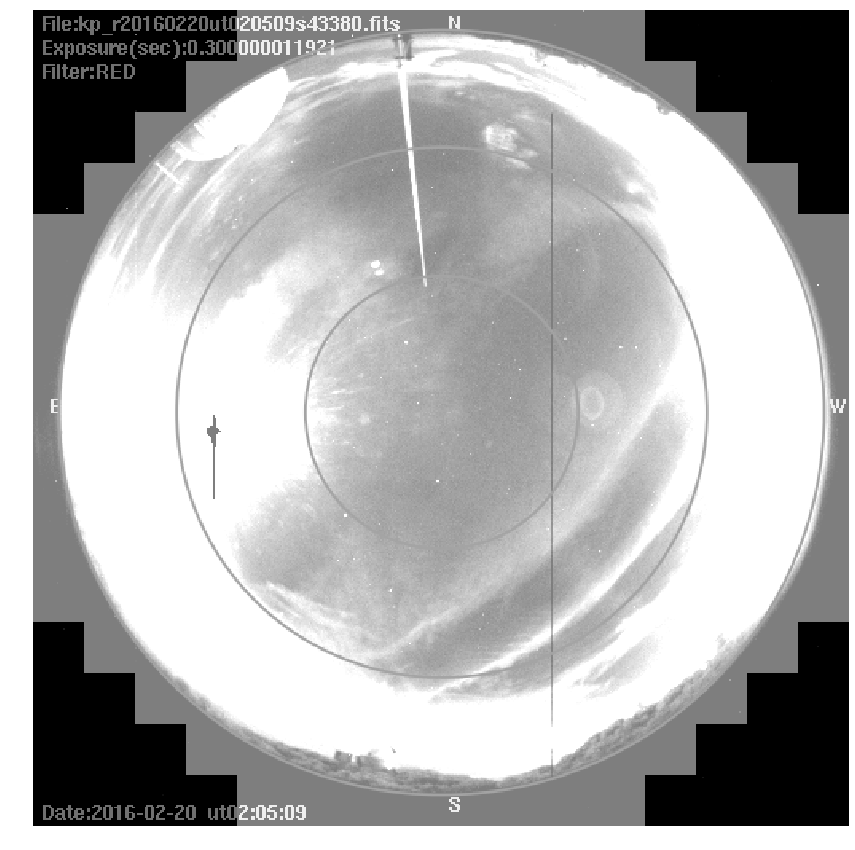

In [178]:
im1 = np.copy(allsky2.data).astype('uint16')
im3 = np.zeros((512,512))
for pos in p2:
    im3[pos[0]-16: pos[0]+16, pos[1]-16:pos[1]+16] = 1

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.imshow(im1, cmap='gray')
ax.imshow(im3, cmap='gray', alpha=0.5)
ax.set_axis_off()

Finds an approximate radius for the 30 degree contour.

In [179]:
import coordinates
r = np.interp(90 - 30, xp=coordinates.theta_kpno, fp=coordinates.r_kpno)
r = r * 240 / 11.6
r

166.360153256705

The following demonstrates how the p2 method breaks down when restricted to 30 degree contours. The overlap in the training patches can clearly be seen to be asymmetrical. 

In [180]:
p2 = []

m = {0: [], 8: [], 16: [], 24: []}

for shift in range(0, 25, 8):
    #shift = 16
    # By subtracting 8 from the upper bound of 512 we prevent 
    # the grid from overruning the image edges for all shifts.
    x = np.arange(16 + shift + 64, 504-63, 32)
    xx, yy = np.meshgrid(x, x, indexing='ij')
    xx = xx.reshape(xx.shape[0], xx.shape[1], 1)
    yy = yy.reshape(xx.shape[0], xx.shape[1], 1)
    grid = np.concatenate((xx, yy), axis=2)
    
    # The masked pixels take out the corners which we don't want to analyze.
    mask = np.ones(grid.shape, dtype=bool)

    # Removes a diagonal long the corners
    for i in range(-4, 4):
        for j in range(-4, 4):
            ii  = i if i < 0 else i+1
            jj  = j if j < 0 else j+1
            if abs(jj) + abs(ii) <= 5:
                mask[i,j] = False
    # Locations set to False are removed, then we reshape
    # into a single list of positions
    p2.append(grid[mask].reshape(-1, 2))
    m[shift].append(grid[mask].reshape(-1, 2))

p2 = np.concatenate(p2)

for key, value in m.items():
    m[key] = np.concatenate(value)

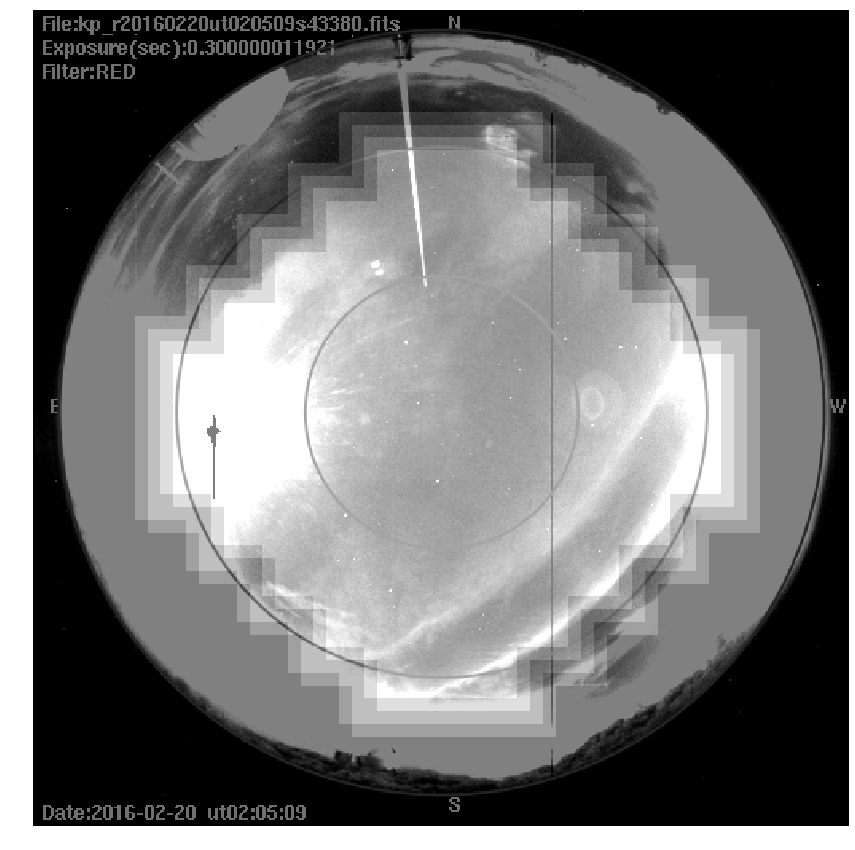

In [181]:
im2 = np.copy(allsky2.data).astype('uint16')
mask = np.zeros((512,512))

for key, value in m.items():
    for pos in value:
        mask[pos[0]-16: pos[0]+16, pos[1]-16:pos[1]+16] += 1

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.imshow(im2, cmap='gray')
ax.imshow(mask, cmap='gray', alpha=0.5)
ax.set_axis_off()

p3 (pixel3) is the method I eventually went with. It is a modified form of version 2, where I now shift each axis individually. Further, instead of just removing each corner I simply find the center of each patch and if its distance to the center of the image (the radius of that center point) is less than the 30 degree contour then I keep it. This is a lot easier to read that the other method. Shifting each axis individually maintains symmetry in coverage in all dimensions.

In [182]:
g1 = []
# We shift each dimension independently so that we can get symmetry in training patches
# and maximium overlap. Some patches in the middle will be overlapped 4-6 times.
for xshift in range(0, 25, 16):
    for yshift in range(0, 25, 16):
        # This code creates a meshgrid and joins and reshapes it
        # so that it becomes a single list of [y, x] positions.
        # We start at 16 because the network slices by doing pos - 16 : pos + 16
        x = np.arange(16+xshift, 513, 32)
        y = np.arange(16+yshift, 513, 32)
        xx, yy = np.meshgrid(x, y, indexing='ij')
        xx = xx.reshape(xx.shape[0], xx.shape[1], 1)
        yy = yy.reshape(xx.shape[0], xx.shape[1], 1)
        grid = np.concatenate((xx, yy), axis=2)

        grid = grid.reshape(-1, 2)
        g1.append(grid)
        
g1 = np.concatenate(g1)

p3 = []
center = (256, 256)
# We here remove any patches where the center of the patch is outside the 
# 30 degree altitude contour. 
for pos in g1:
    x1 = pos[0] - center[0]
    y1 = center[1] - pos[1]
    r = math.hypot(x1, y1)

    # 167 roughly corresponds to 30 degrees up from the horizon.
    if r < 167:
        p3.append([pos[0], pos[1]])
print(len(p3))

341


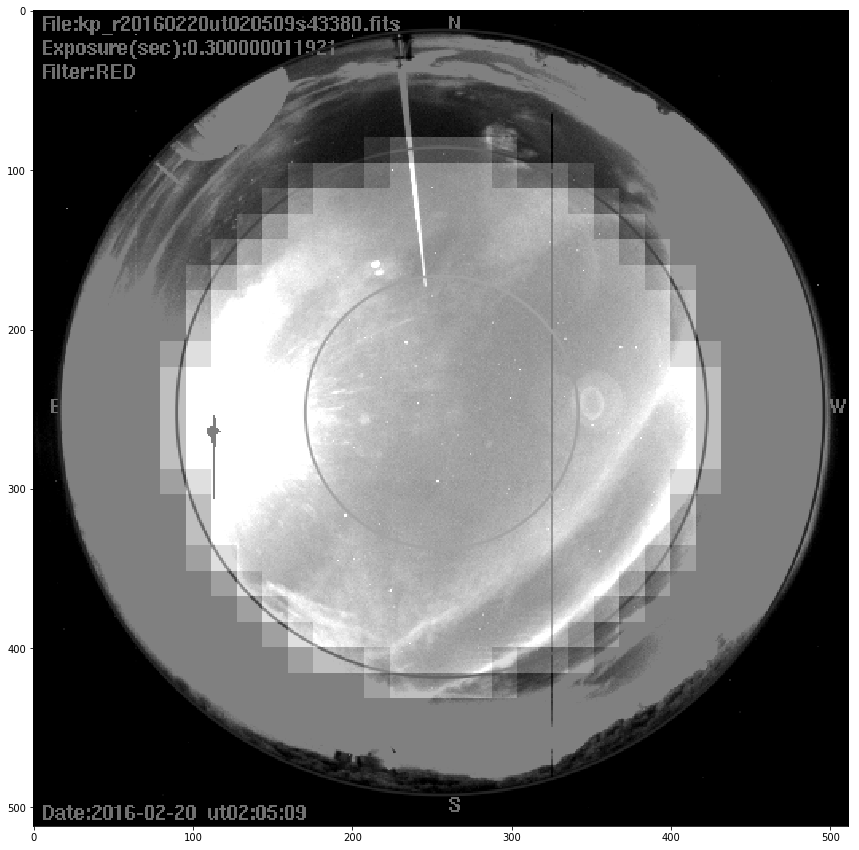

In [183]:
im2 = np.copy(allsky2.data).astype('uint16')
mask = np.zeros((512,512))

for pos in p3:
    #print(pos)
    mask[pos[0]-16: pos[0]+16, pos[1]-16:pos[1]+16] += 1


fig, ax = plt.subplots()
fig.set_size_inches(15,15)
#ax.imshow(im2, cmap='gray')
#ax.imshow(mask, cmap='gray', alpha=0.5)
#ax.set_axis_off()

plt.imshow(im2, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.5)
x = np.arange(16+16, 513, 32)
#plt.xticks(x)
#plt.yticks(x)
#plt.grid(color='m')

# Spacewatch
The following cells apply the p3 method to the spacewatch images with the apppropriate corrections. Mainly increasing the size of the grid (as the spacewatch images are 1024x1024) and the radius of the 30 degree altitude contour (for the same reason)

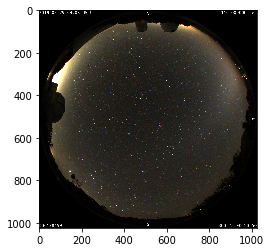

In [184]:
name = "c_ut040805.jpg"
loc = os.path.join("Images", *["data", "train", "sw", name])
with open(loc, 'rb') as f:
    im = Image.open(f).convert('RGB')
    im = np.asarray(im)#.reshape((512, 512))
    
plt.imshow(im)

In [185]:
allsky = AllSkyImage(name, None, "SW", im)
allsky2 = image.draw_contours(allsky)

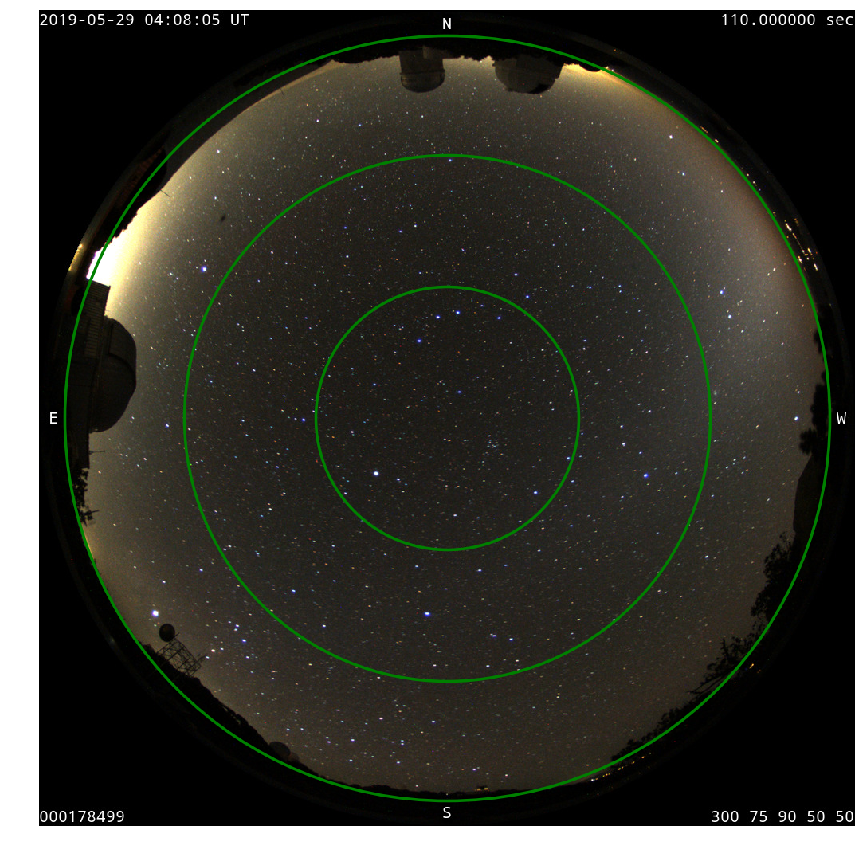

In [186]:
im1 = np.copy(allsky2.data).astype("uint16")

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.imshow(im1, cmap="gray")
ax.set_axis_off()

In [187]:
g1 = []
center = (512, 512)
# We shift each dimension independently so that we can get symmetry in training patches
# and maximium overlap. Some patches in the middle will be overlapped 4-6 times.
for xshift in range(0, 25, 16):
    for yshift in range(0, 25, 16):
        # This code creates a meshgrid and joins and reshapes it
        # so that it becomes a single list of [y, x] positions.
        # We start at 16 because the network slices by doing pos - 16 : pos + 16
        x = np.arange(16+xshift, 1025, 32)
        y = np.arange(16+yshift, 1025, 32)
        xx, yy = np.meshgrid(x, y, indexing='ij')
        xx = xx.reshape(xx.shape[0], xx.shape[1], 1)
        yy = yy.reshape(xx.shape[0], xx.shape[1], 1)
        grid = np.concatenate((xx, yy), axis=2)

        grid = grid.reshape(-1, 2)
        g1.append(grid)
        
g1 = np.concatenate(g1)
p4 = []

# We here remove any patches where the center of the patch is outside the 
# 30 degree altitude contour. 
for pos in g1:
    x1 = pos[0] - center[0]
    y1 = center[1] - pos[1]
    r = math.hypot(x1, y1)

    # 167 roughly corresponds to 30 degrees up from the horizon.
    if r < 330:
        p4.append([pos[0], pos[1]])

print(np.asarray(p4).shape)

(1353, 2)


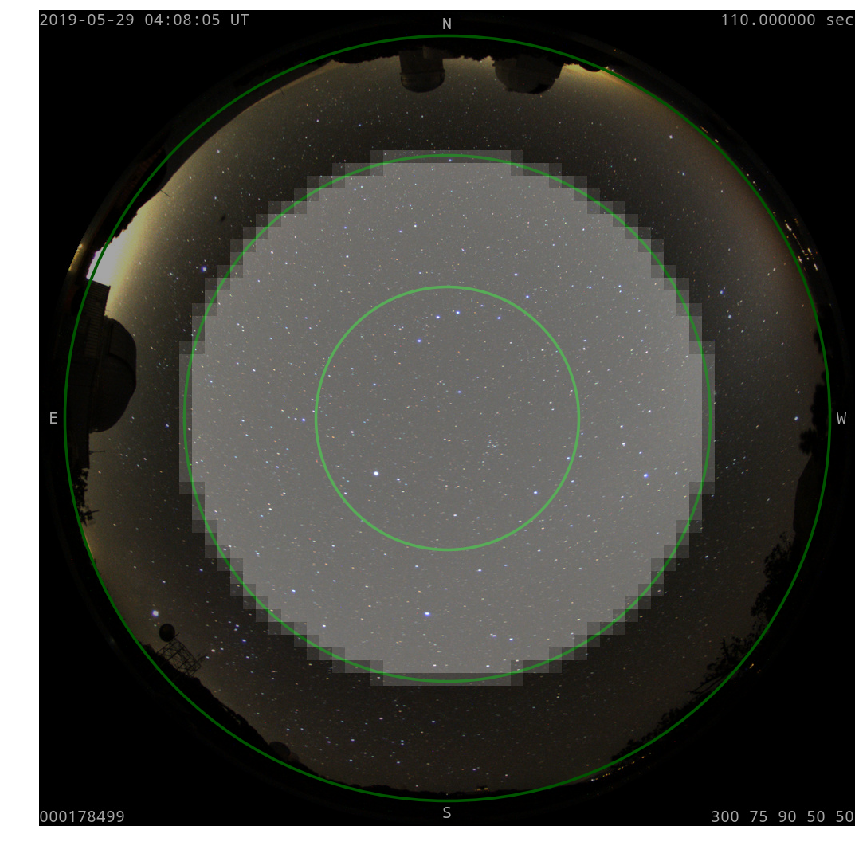

In [188]:
im1 = np.copy(allsky2.data).astype("uint16")
im2 = np.zeros((1024, 1024))
for pos in p4:
    im2[pos[0]-16: pos[0]+16, pos[1]-16:pos[1]+16] += 1

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.imshow(im1)
ax.imshow(im2, cmap="gray", alpha=0.35)
ax.set_axis_off()